In [1]:
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
from itertools import islice
import numpy as np
from skimage.external import tifffile
from skimage.external.tifffile import imread
import matplotlib.pyplot as plt
import ipywidgets as widgets
import random
from scipy.ndimage.morphology import binary_erosion as br
from skimage import morphology as skmor
from scipy import ndimage
from PIL import Image, ImageDraw
import numpy.ma as ma
from skimage.measure import label, regionprops

In [2]:
import seaborn as sns

## Pixel Distribution of HP1 (HP1B) and DAPI signal
- Select random 10 cells from the chosen dataset
- calculate HP1 (HP1B) signal and DAPI signal for each pixel of the image
- plot HP1 signal vs DAPI signal for each cell 
- look for any pattern noticed - ex) normal linear relationship, grouping in the plots, etc

In [3]:
bigDir=r'Z:\CookLab\Liu\20190816_organizedData_MCM_loading'

In [4]:
newfile=f'{bigDir}\\new dataset\signals_new_v5.csv'

In [5]:
newdata=pd.read_csv(newfile)

In [6]:
newdata=newdata.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

In [7]:
newdata.head()

,file,original cell name,movie,last frame movie position x,last frame movie position y,ab1 (MCM),ab1 ch,ab2 (heterochromatin),ab2 ch,DAPI ch,...,mol_age_mod,nuc_hp1b_total,inner_hp1b_total,outer_hp1b_total,nuc_hp1b_het,inner_hp1b_het,outer_hp1b_het,nuc_hp1b_eu,inner_hp1b_eu,outer_hp1b_eu
0,20191203_cell-00.czi,20191125-01-17,191125pcnat_dhbr_cdc6vxy01,678.301,200.931,MCM3,1,HP1beta,2,3,...,0.444,1.415176e+09,425500564.0,9.896759e+08,550518042.0,321679433.0,228838609.0,8.646584e+08,103821131.0,7.608373e+08
1,20191203_cell-01.czi,20191125-01-20,191125pcnat_dhbr_cdc6vxy01,1552.152,240.479,MCM3,1,HP1beta,2,3,...,1.373,2.175016e+09,804184935.0,1.370831e+09,896267478.0,567124747.0,329142731.0,1.278748e+09,237060188.0,1.041688e+09
2,20191203_cell-02.czi,20191125-01-23,191125pcnat_dhbr_cdc6vxy01,1131.436,318.530,MCM3,1,HP1beta,2,3,...,1.371,1.933001e+09,666820604.0,1.266180e+09,732487366.0,444813519.0,287673847.0,1.200514e+09,222007085.0,9.785064e+08
3,20191203_cell-03.czi,20191125-01-25,191125pcnat_dhbr_cdc6vxy01,1650.585,324.968,MCM3,1,HP1beta,2,3,...,0.208,1.062142e+09,233589820.0,8.285525e+08,403943621.0,187675893.0,216267728.0,6.581987e+08,45913927.0,6.122848e+08
4,20191203_cell-04.czi,20191125-01-32,191125pcnat_dhbr_cdc6vxy01,1466.687,426.815,MCM3,1,HP1beta,2,3,...,0.345,1.717888e+09,546330833.0,1.171557e+09,697150763.0,424718652.0,272432111.0,1.020738e+09,121612181.0,8.991254e+08


### taking a sample of n=10 from the new dataset that is not deconvolized

In [8]:
sample=newdata.loc[(newdata.decon==False),:].sample(n=10, random_state=107)

In [9]:
sample

,file,original cell name,movie,last frame movie position x,last frame movie position y,ab1 (MCM),ab1 ch,ab2 (heterochromatin),ab2 ch,DAPI ch,...,mol_age_mod,nuc_hp1b_total,inner_hp1b_total,outer_hp1b_total,nuc_hp1b_het,inner_hp1b_het,outer_hp1b_het,nuc_hp1b_eu,inner_hp1b_eu,outer_hp1b_eu
65,20191203_cell-85.czi,20191125-05-84,191125pcnat_dhbr_cdc6vxy05,1381.073,1396.479,MCM3,1,HP1beta,2,3,...,0.369,1.610488e+09,428951784.0,1.181536e+09,620816593.0,324415800.0,296400793.0,9.896715e+08,104535984.0,885135510.0
42,20191203_cell-56.czi,20191125-10-104,191125pcnat_dhbr_cdc6vxy10,1522.443,1162.142,MCM3,1,HP1beta,2,3,...,0.553,1.001341e+09,235493985.0,7.658470e+08,338153855.0,177354553.0,160799302.0,6.631871e+08,58139432.0,605047655.0
127,20191203_cell-157.czi,20191125-16-42,191125pcnat_dhbr_cdc6vxy16,1718.927,920.523,MCM3,1,HP1beta,2,3,...,0.276,5.720821e+08,100399514.0,4.716826e+08,172060220.0,59360834.0,112699386.0,4.000219e+08,41038680.0,358983223.0
18,20191203_cell-25.czi,20191125-01-99,191125pcnat_dhbr_cdc6vxy01,1502.805,1480.651,MCM3,1,HP1beta,2,3,...,1.328,1.690386e+09,555811146.0,1.134575e+09,604441084.0,354657357.0,249783727.0,1.085945e+09,201153789.0,884790834.0
55,20191203_cell-74.czi,20191125-05-28,191125pcnat_dhbr_cdc6vxy05,1421.341,419.261,MCM3,1,HP1beta,2,3,...,1.063,1.458071e+09,495331506.0,9.627391e+08,565243572.0,357224466.0,208019106.0,8.928271e+08,138107040.0,754720039.0
23,20191203_cell-30.tiff,20191125-01-10,191125pcnat_dhbr_cdc6vxy01,275.057,144.649,MCM3,1,HP1beta,2,3,...,0.208,6.813998e+08,129622425.0,5.517773e+08,233585774.0,98160909.0,135424865.0,4.478140e+08,31461516.0,416352461.0
118,20191203_cell-148.czi,20191125-12-84,191125pcnat_dhbr_cdc6vxy12,385.605,946.541,MCM3,1,HP1beta,2,3,...,0.747,1.075397e+09,271799979.0,8.035973e+08,382758748.0,181321929.0,201436819.0,6.926385e+08,90478050.0,602160458.0
108,20191203_cell-137.czi,20191125-11-82,191125pcnat_dhbr_cdc6vxy11,916.914,921.865,MCM3,1,HP1beta,2,3,...,0.701,1.340251e+09,442330664.0,8.979200e+08,509021593.0,325983023.0,183038570.0,8.312291e+08,116347641.0,714881453.0
102,20191203_cell-130.czi,20191125-08-101,191125pcnat_dhbr_cdc6vxy08,1237.094,1258.126,MCM3,1,HP1beta,2,3,...,0.721,1.285848e+09,390107622.0,8.957405e+08,487715875.0,290984487.0,196731388.0,7.981323e+08,99123135.0,699009158.0
115,20191203_cell-145.czi,20191125-12-39,191125pcnat_dhbr_cdc6vxy12,1285.072,463.128,MCM3,1,HP1beta,2,3,...,0.958,1.341019e+09,438332941.0,9.026858e+08,527874753.0,307195534.0,220679219.0,8.131440e+08,131137407.0,682006613.0


In [10]:
# testing for the first row of the sample taken
i = 0

In [11]:
test=sample.iloc[0]

In [12]:
test['path']

'Z:\\CookLab\\Liu\\20190816_organizedData_MCM_loading\\new dataset\\20191203_cell\\data_tiff\\20191203_cell-85.tif'

##### files needed to be open
1. cell image
2. nucleus mask

##### signals to be calculated
1. DAPI signal 
2. HP1beta signal

***note!***
> although we calculated the hp1beta and dapi signal for the image, that signal was for entire image (or the sum of the pixels. what we want is signals calculated for each cell.

In [13]:
cell=imread(test['path'])

In [14]:
nucPath=(test.path.replace('data_tiff','segmentation_nucleus_Otsu'))
nucPath=nucPath.replace('.tif','_nucleus.tif')
nuc=imread(nucPath)

In [15]:
print('shape of the cell image: ', cell.shape)
print('shape of nucleus mask: ', nuc.shape)

shape of the cell image:  (27, 3, 380, 380)
shape of nucleus mask:  (27, 380, 380)


<IPython.core.display.Javascript object>


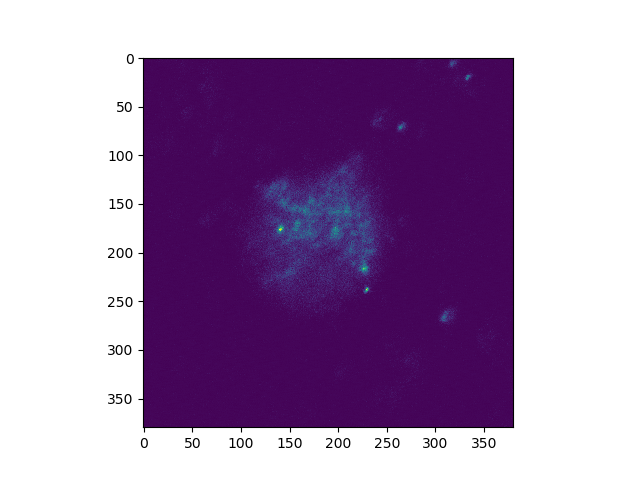

In [16]:
%matplotlib notebook
# showing the 15th slide of the 2nd channel (HP1beta) of the cell image - cell image is 4d since it has channels
plt.imshow(cell[15,1,:,:])

<IPython.core.display.Javascript object>


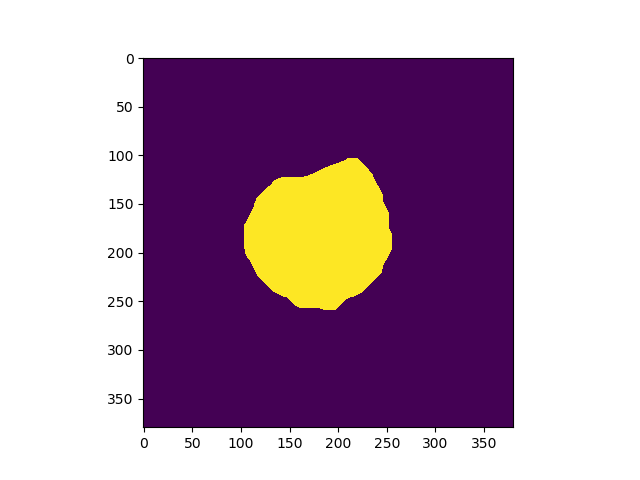

In [17]:
%matplotlib notebook
#showing the 15th slide of the nucleus mask - nucleus mask does not have any channel (3d image)
plt.imshow(nuc[15])

In [18]:
nuc=nuc.astype(bool)

In [19]:
# selecting every slide of the selected channel, which is hp1beta channel.
myChannel=cell[:,1,:,:] 

In [20]:
## masking the image
myChannel[~nuc]=0

<IPython.core.display.Javascript object>


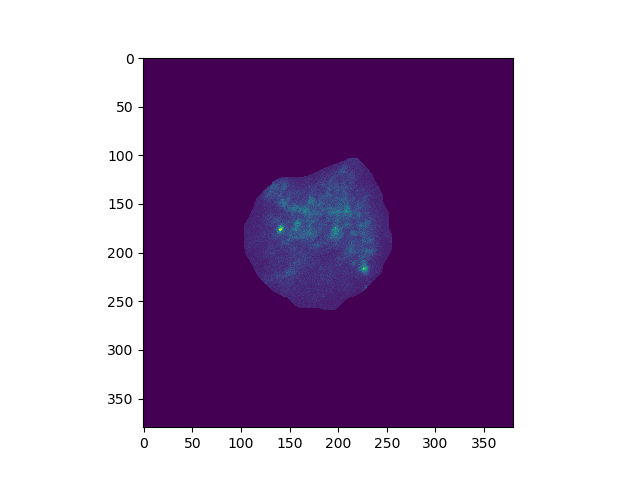

In [21]:
%matplotlib notebook
plt.imshow(myChannel[15])

In [22]:
myChannel.shape

(27, 380, 380)

In [23]:
myChannel.dtype

dtype('uint16')

In [24]:
myChannel=myChannel.astype(np.ndarray)

In [25]:
# DAPI channel
myChannel1=cell[:,2,:,:]

In [26]:
myChannel1[~nuc]=0

<IPython.core.display.Javascript object>


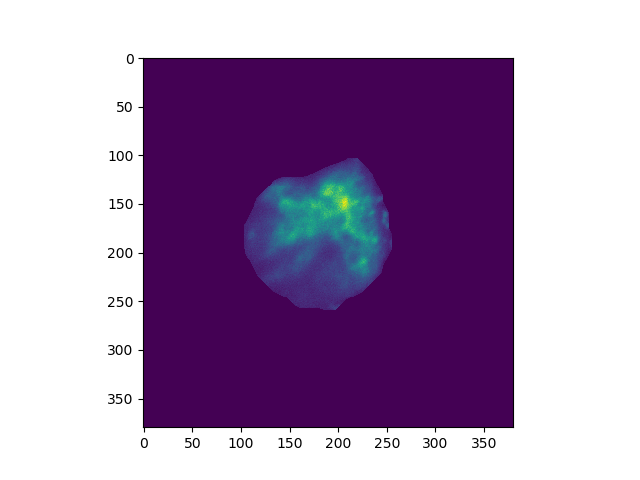

In [27]:
%matplotlib notebook
plt.imshow(myChannel1[15])

<IPython.core.display.Javascript object>


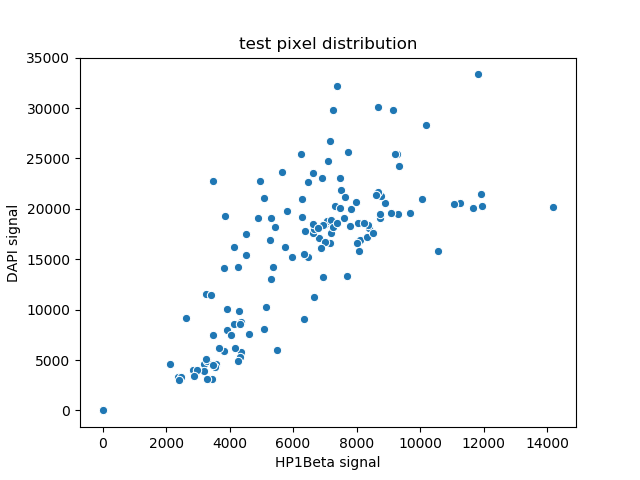

Text(0.5, 1.0, 'test pixel distribution')

In [28]:
#testing plotting

## ploting 15th slide, 150th pixels
%matplotlib notebook
sns.scatterplot(x=myChannel[15,150,:],y=myChannel1[15,150,:])
plt.xlabel('HP1Beta signal')
plt.ylabel('DAPI signal')
plt.title('test pixel distribution')

27 380 380


<IPython.core.display.Javascript object>


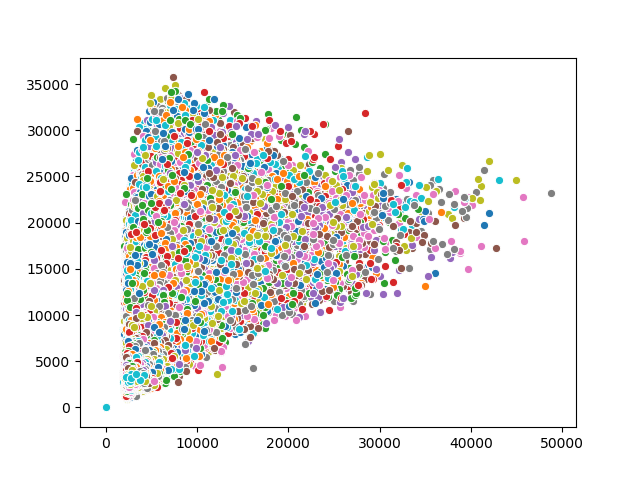

In [31]:
%matplotlib notebook
slides, xs, ys = (myChannel.shape)
print(slides, xs, ys)

for slide in range(slides):
    for x in range(xs):
        sns.scatterplot(x=myChannel[slide,x,:],y=myChannel1[slide,x,:])
    

## per slide

In [29]:
df=pd.DataFrame(columns=['hp1b','dapi'])

In [30]:
df['hp1b']=myChannel.sum(-1).sum(-1)

In [31]:
df['dapi']=myChannel1.sum(-1).sum(-1)

27 380 380


<IPython.core.display.Javascript object>


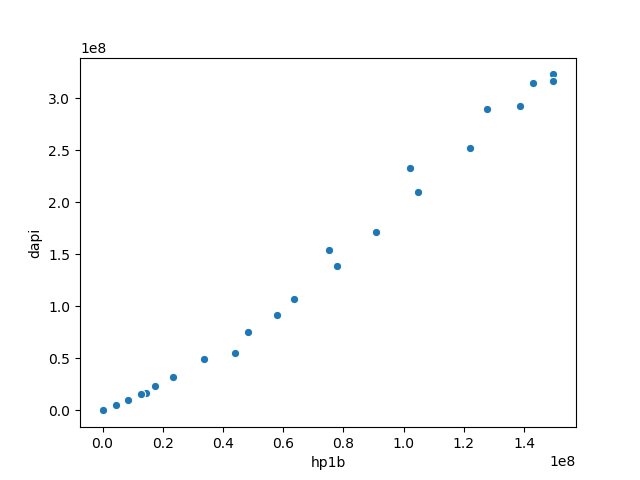

In [32]:
%matplotlib notebook
slides, xs, ys = (myChannel.shape)
print(slides, xs, ys)

sns.scatterplot(x='hp1b',y='dapi',data=df)

<IPython.core.display.Javascript object>


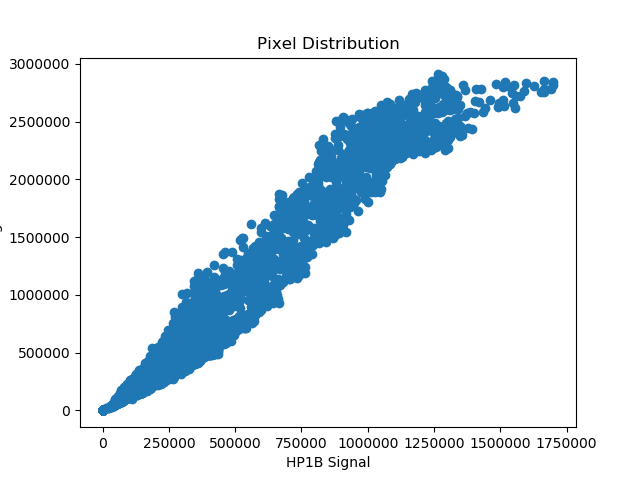

Text(0.5, 1.0, 'Pixel Distribution')

In [33]:
%matplotlib notebook
plt.scatter(x=myChannel.sum(-1),y=myChannel1.sum(-1))
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title('Pixel Distribution')

In [34]:
df=pd.DataFrame(columns=['hp1b_x','hp1b_y','dapi_x','dapi_y'])

In [35]:
for i in range(myChannel.shape[0]):

    df.loc[i,'hp1b_x']=myChannel[i].sum(-1)
    df.loc[i,'hp1b_y']=myChannel[i].sum(0)
    df.loc[i,'dapi_x']=myChannel1[i].sum(-1)
    df.loc[i,'dapi_y']=myChannel[i].sum(0)

In [36]:
df.head()

,hp1b_x,hp1b_y,dapi_x,dapi_y
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


<IPython.core.display.Javascript object>


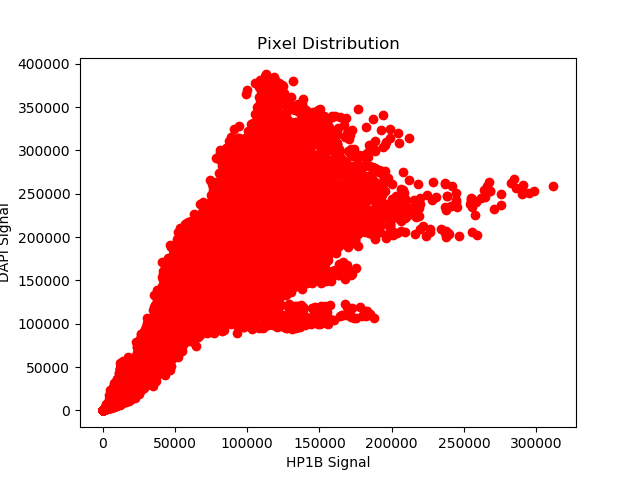

Text(0.5, 1.0, 'Pixel Distribution')

In [45]:
%matplotlib notebook
plt.scatter(x=myChannel.sum(0),y=myChannel1.sum(0),color='red')
#plt.scatter(x=myChannel.sum(-1),y=myChannel1.sum(-1),color='blue',alpha=0.1)
plt.xlabel('HP1B Signal')
plt.ylabel('DAPI Signal')
plt.title('Pixel Distribution')